# Search Scheduler

최적의 하이퍼파라메터와 최적의 네트워크 아키텍처를 효율적으로 찾으려면 컴퓨팅 리소스를 효율적으로 사용해야 합니다. AutoGluon에서는 아래 3가지의 스케줄러를 지원합니다.
- FIFO Scheduler(`autogluon.core.scheduler.FIFOScheduler`): 기본적인 스케줄러로 선입선출(First In, First Out) 방식을 사용
- Hyperband Scheduler(`autogluon.core.scheduler.HyperbandScheduler`): MAB(Multi-Armed Bandits) 기반의 스케줄러로 중간 결괏값에 기반하여 더 좋을 것으로 예상되는 검색 공간에 더 많은 리소스를 할당하며, 나쁠 것으로 사용되는 검색 공간에는 early stopping으로 훈련 종료
- RL Scheduler(`autogluon.core.scheduler.RLScheduler`): 사용자가 정의한 검색 공간(search space)을 기반으로 생성된 LSTM 컨트롤러로 강화 학습을 사용하는 스케줄러

본 핸즈온에서는 FIFO Scheduler와 Hyperband Scheduler를 비교해 봅니다.

In [1]:
%load_ext autoreload
%autoreload 2

## Search Space Definition

학습률(learning rate) 및 가중치 감소(weight decay)에 대한 파라메터 검색 공간을 데코레이터에서 정의합니다. Epoch는 10회로 고정합니다.

In [2]:
import numpy as np
import autogluon.core as ag

@ag.args(
    lr=ag.space.Real(1e-3, 1e-2, log=True),
    wd=ag.space.Real(1e-3, 1e-2),
    epochs=10)
def train_fn(args, reporter):
    for e in range(args.epochs):
        dummy_accuracy = 1 - np.power(1.8, -np.random.uniform(e, 2*e))
        reporter(epoch=e+1, accuracy=dummy_accuracy, lr=args.lr, wd=args.wd)

<br>

## 1. FIFO Scheduler

이 스케줄러는 trial을 순서대로 실행합니다. 물론, 가용 리소스가 훈련 작업보다 더 많은 경우에는 여러 훈련 작업들이 병렬로 실행될 수 있습니다.

In [3]:
!pip install -qU scikit-optimize

In [4]:
rnd_scheduler = ag.scheduler.FIFOScheduler(train_fn,
                                       resource={'num_cpus': 2, 'num_gpus': 0},
                                       num_trials=40,
                                       #searcher='skopt',
                                       reward_attr='accuracy',
                                       time_attr='epoch')
rnd_scheduler.run()
rnd_scheduler.join_jobs()

print('Best config: {}, best reward: {}'.format(rnd_scheduler.get_best_config(), rnd_scheduler.get_best_reward()))    

  0%|          | 0/40 [00:00<?, ?it/s]

Best config: {'lr': 0.0021840206209573563, 'wd': 0.008554043397071515}, best reward: 0.9999723710922915


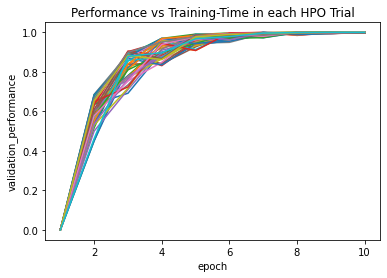

In [5]:
rnd_scheduler.get_training_curves(plot=True, use_legend=False)

<br>

## 2. Hyperband Scheduler

Hyperband 스케줄러는 컴퓨팅 리소스를 확보하기 위해, 훈련 초기 단계에서 유망해 보이지 않는 검색 공간에 대해 훈련 시도를 종료하는 early stopping이 디폴트로 설정되어 있습니다. (조정 가능)

HyperbandScheduler의 원활한 동작을 위해서 최대 Epoch 수를 반드시 설정해야 하며, 이는 `max_t` 인자로 설정 가능합니다. 만약 이 인자값이 누락된 경우 `train_fn.args.epochs`(위에서 `epochs = 10`으로 설정함) 또는 `train_fn.args.max_t`을 통해 자동으로 설정합니다.

In [6]:
hb_scheduler = ag.scheduler.HyperbandScheduler(train_fn,
                                            resource={'num_cpus': 2, 'num_gpus': 0},
                                            num_trials=40,
                                            reward_attr='accuracy',
                                            time_attr='epoch',
                                            grace_period=1,
                                            reduction_factor=3,
                                            type='stopping')
hb_scheduler.run()
hb_scheduler.join_jobs()
print('Best config: {}, best reward: {}'.format(hb_scheduler.get_best_config(), hb_scheduler.get_best_reward()))    

  0%|          | 0/40 [00:00<?, ?it/s]

Best config: {'lr': 0.001525874424365216, 'wd': 0.0065580313180482845}, best reward: 0.999963885074381


아래 plotting 결과를 유심히 살펴 보시면, FIFOScheduler와 달리 몇몇 trial들은 조기 중단되는 것을 확인할 수 있으며, 일부 trial만 epoch 10까지 실행됩니다. 따라서, 더 많은 trial을 시도할 수 있습니다.

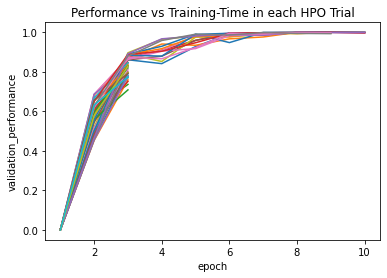

In [7]:
hb_scheduler.get_training_curves(plot=True, use_legend=False)

In [8]:
results_hb = [v[1]['accuracy'] for v in hb_scheduler.training_history.values()]
results_random = [v[1]['accuracy'] for v in rnd_scheduler.training_history.values()]

In [9]:
import statistics
results1 = [statistics.mean(results_random[i:i+2]) for i in range(0, len(results_random), 2)]
results2 = [statistics.mean(results_hb[i:i+2]) for i in range(0, len(results_hb), 2)]

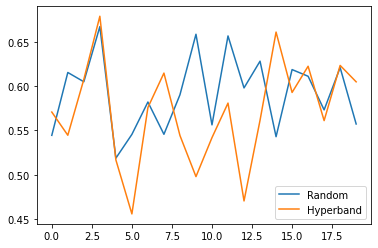

In [10]:
import matplotlib.pyplot as plt
plt.plot(range(len(results1)), results1, range(len(results2)), results2)
plt.legend(['Random', 'Hyperband'])